In [1]:
from __future__ import print_function, division
import sys
import os
import os.path 
import numpy as np
from numpy.linalg import norm
import string
import json
import gensim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot  as plt
#!{sys.executable} -m pip install gensim sklearn matplotlib
import gensim

In [24]:
# Install Gensim if needed
#os.chdir(r'C:\Users\JosipKoprcina\Desktop\IRProjectMovieScriptGenderBiasRetrieval')
os.chdir(r'/mnt/c/Users/baran/Documents/Huiswerk/Master/IR')
fname = 'GN-vectors.bin'
if (not(os.path.isfile(fname))):
    model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
    model.save(fname)
model = gensim.models.KeyedVectors.load(fname, mmap='r')

In [25]:
# First 16 dimensions of the word vector for China (from 300)
model.get_vector("China")[1:16]

memmap([ 0.13574219,  0.10888672,  0.08300781, -0.12792969, -0.22753906,
         0.15136719, -0.0456543 , -0.06542969,  0.03442383, -0.140625  ,
        -0.02355957,  0.24609375, -0.27148438, -0.1875    , -0.11865234],
       dtype=float32)

In [27]:
## Importing bad and good bias words
################################### CHANGE ROUTE FOR CODE TO WORK ####################################################
os.chdir(r'/mnt/c/Users/baran/Documents/Huiswerk/Master/IR/IRProjectMovieScriptGenderBiasRetrieval')
bad_bias_words = open("BadBias.txt").read().split("\n")
good_bias_words = open("GoodBias.txt").read().split("\n")

## Initialzing needed dictionaries for single and paired words
bad_bias_unigrams = []
good_bias_unigrams = []

## Adding bad bias words from basic text to dictionaries
for x in bad_bias_words:
    if(len(x.strip().split(" ")) == 1):
        bad_bias_unigrams.append(x.strip())
        
## Adding good bias words from basic text to dictionaries
for x in good_bias_words:
    if(len(x.strip().split(" ")) == 1):
        good_bias_unigrams.append(x.strip())

In [28]:
## PCA projection of the word embeddings of a given list of words
def words_pca(word_list, transform = 'pca'):
    # Looking up the vectors per word
    bias_vectors = [model[word] for word in word_list]
    # scaling the wordvectors
    bias_vectors = StandardScaler().fit_transform(bias_vectors)
    # applying PCA with 2 components
    if transform == 'pca':
        pca = PCA(n_components=2)
        bias_pca = pca.fit_transform(bias_vectors)
    elif transform == 'tsne':
        bias_pca = TSNE(n_components=2).fit_transform(bias_vectors)
    else:
        # bias_pca = umap.UMAP().fit_transform(bias_vectors)
        bias_pca = []
    return bias_pca

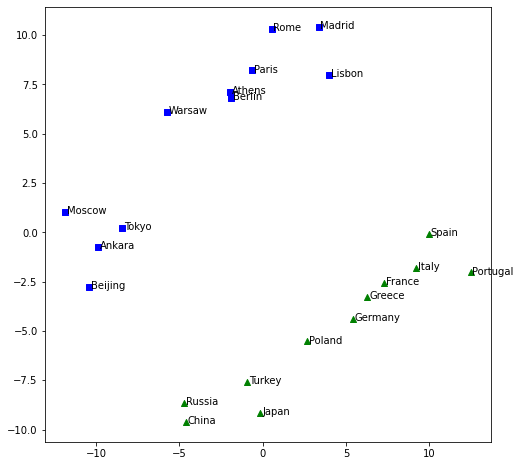

In [29]:
# Countries and Capitals from W2V paper:
countries = ['China', 'Russia', 'Japan', 'Turkey', 'Poland', 'Germany','France', 'Italy', 'Greece', 'Spain', 'Portugal']
capitals = ['Beijing', 'Moscow', 'Tokyo', 'Ankara', 'Warsaw', 'Berlin','Paris', 'Rome', 'Athens', 'Madrid', 'Lisbon']

# Projecting on 2D using PCA
words = countries + capitals
ccproj = words_pca(words, transform = 'pca')
plt.figure(figsize=(8,8))

# Plotting the PCA with words
for i,word in enumerate(words):
    x = ccproj[i,0]
    y = ccproj[i,1]
    if word in countries:
        plt.scatter(x, y, marker='^', c='g')
    elif word in capitals:
        plt.scatter(x, y, marker='s', c='b')
    plt.text(x+0.1, y-0.1, word, fontsize=10)
plt.show()

In [30]:
model.most_similar(positive=['Spain','Rome'], negative = ['Madrid'], topn = 1)
model.most_similar(positive=['Beijing','Japan'], negative = ['China'], topn = 1)
print("Most similar to computer_programmer - he + she: \n", model.most_similar(positive = ['computer_programmer', 'she'], negative = ['he'], topn = 5), "\n")
print("Most similar to beautician - she + he: \n", model.most_similar(positive= ['beautician', 'he'], negative = ['she'], topn = 5))

Most similar to computer_programmer - he + she: 
 [('homemaker', 0.5700256824493408), ('housewife', 0.5342153906822205), ('businesswoman', 0.5196776390075684), ('saleswoman', 0.5168929696083069), ('graphic_designer', 0.5157608985900879)] 

Most similar to beautician - she + he: 
 [('barber', 0.6375421285629272), ('handyman', 0.5406479835510254), ('carpenter', 0.5381854772567749), ('mechanic', 0.526857852935791), ('electrician', 0.5152750015258789)]


In [31]:
## Putting our biased words into a vector space to see are they really fit for the problem
def doPCA(pairs, embedding, num_components=10):
    matrix = []
    for a, b in pairs:
        center = (embedding[a] + embedding[b]) / 2
        matrix.append(embedding[a] - center)
        matrix.append(embedding[b] - center)

    matrix = np.array(matrix)
    pca = PCA(n_components=num_components)
    pca.fit(matrix)
    return pca

# Calculate bias per word
def genderBias(genderNeutralWords, genderdirection, embedding):
    sp = sorted([(embedding[w].dot(genderdirection), w) for w in genderNeutralWords])
    return sp

Text(0, 0.5, 'Variance Ratio')

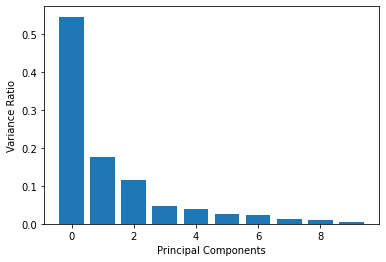

In [35]:
# Check if the first variance explains the gender enough
gender_pairs = [['she','he'], 
                ['her','his'],
                ['woman','man'],
                ['mary','john'],
                ['herself','himself'],
                ['daughter','son'],
                ['mother','father'],
                ['gal','guy'],
                ['girl','boy'],
                ['female','male']
]

pcarandom = doPCA(gender_pairs,model)
(plt.bar(range(10), pcarandom.explained_variance_ratio_))
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio")

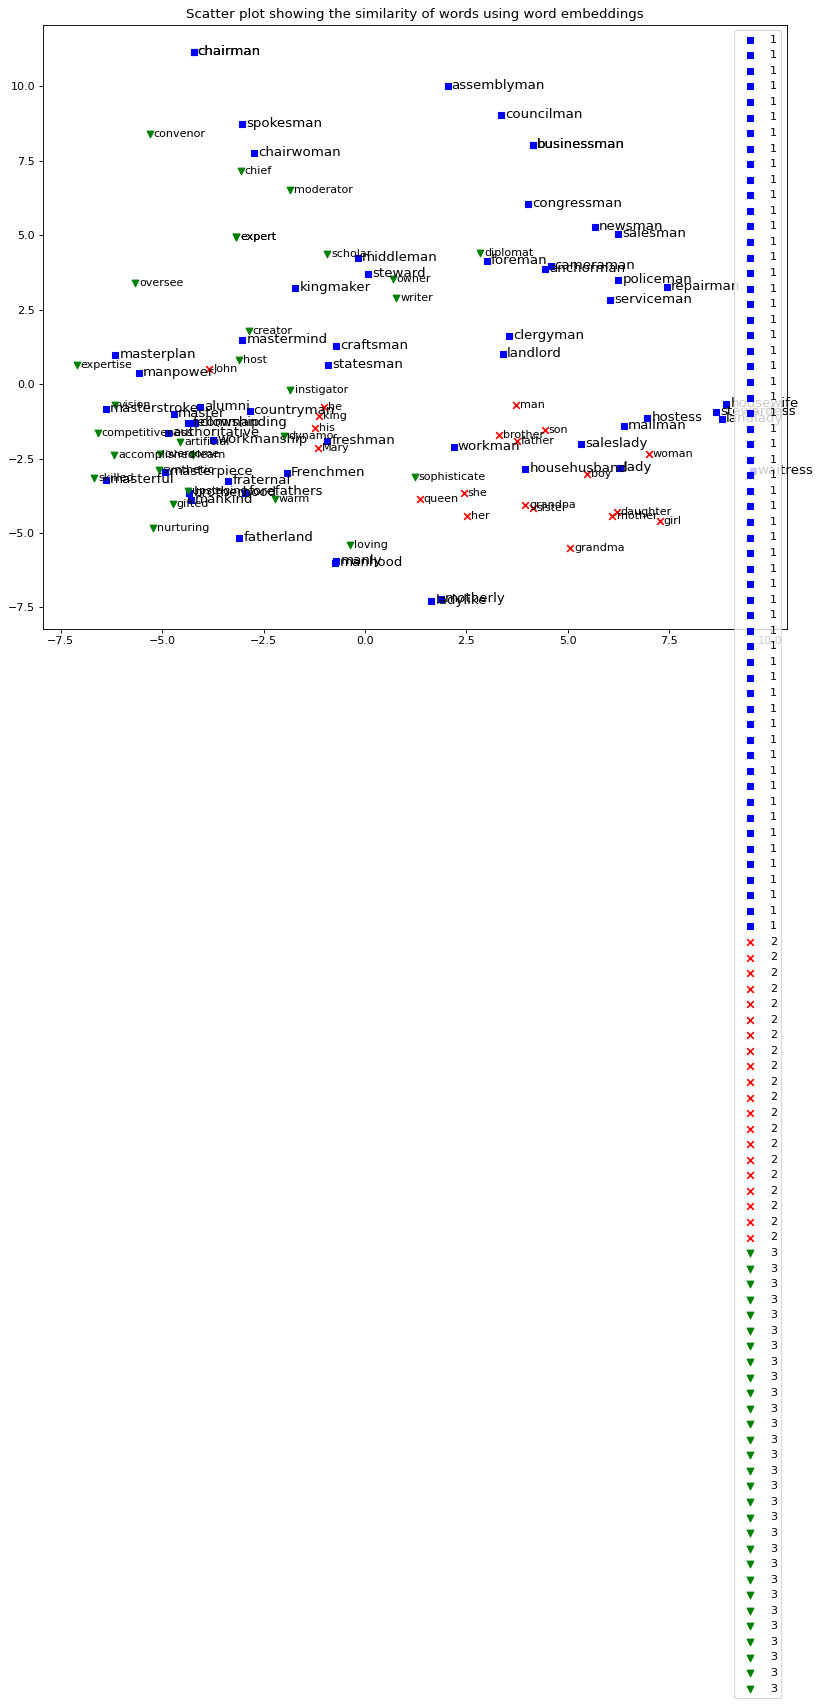

In [32]:
# Plotting the PCA with words
super_gendered = ['king', 'queen', 'brother', 'sister', 'mother', 'father','she', 'woman', 'he', 'man', 'grandpa', 'grandma', 'boy','girl','her', 'his', 'daughter', 'son', 'Mary', 'John']
non_biased = ['owner', 'expert', 'chief' ,'learn' ,'overcome' ,'expert' ,'gifted' ,'accomplished','host' ,'moderator' 
              ,'convenor' ,'skilled' ,'creator' ,'instigator' ,'oversee' ,'vision' ,'artificial' ,'synthetic'
              ,'dynamo' ,'scholar' ,'writer' ,'sophisticate' ,'loving' ,'warm' ,'nurturing' ,'upstaging' ,'competitiveness' 
              ,'diplomat' ,'expertise']
bw = bad_bias_unigrams + super_gendered + non_biased
bias_pca = words_pca(bw, transform = 'pca')

plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("Scatter plot showing the similarity of words using word embeddings")
for i,word in enumerate(bw):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    if word in bad_bias_unigrams:
        plt.scatter(x, y, marker='s', color='blue', label="1")
        plt.text(x+0.1, y-0.1, word, fontsize=12)
    elif word in super_gendered:
        plt.scatter(x, y, marker='x', color='red', label="2")
        plt.text(x+0.1, y-0.1, word, fontsize=10)
    else:
        plt.scatter(x, y, marker='v', color='green', label="3")
        plt.text(x+0.1, y-0.1, word, fontsize=10)
plt.legend()
plt.show()